# Path Start Mech Int Investigation #23

In this notebook we explore how the model is doing prediction of the first path token in the maze (ie. the token that immediately comes after the `PATH_START` token), to this end we use:

* Logit Lens
* Direct Logit Attribution
* Activation Patching

In summary, we find that the majority of computation associated with this task is in the form of MLP computation (in particular in MLP10 and MLP11) but that there does appear to be a few heads within early layers (Layer 0, 1 and 2) that are also playing some role. Further evals outside of this notebook however are suggestive of this instance of maze-transformer doing some form of memorization (atleast overfitting to its training data and not generalising OOD), for this reason, this study has not yet been taken further.

This notebook takes significant inspiration from two great resources:

* Nanda's [Exploratory Analysis Demo](https://github.com/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb) Notebook
* Janiak & Heimersheim's [Python docstrings](https://colab.research.google.com/drive/17CoA1yARaWHvV14zQGcI3ISz1bIRZKS5) Notebook

# Setup

In [1]:
# standard library
import os
from copy import deepcopy
from pathlib import Path
from functools import partial
import typing

# Numerical Computing
import numpy as np
import torch
import einops
import pandas as pd
from fancy_einsum import einsum
# from sklearn.decomposition import PCA
# from sklearn import preprocessing
from jaxtyping import Float, Int
# from torchtyping import TensorType as TT

# Pytorch
import torch
import torch.nn.functional as F

# plotting
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import HTML
# import seaborn
# from neel_plotly import imshow, line

# TransformerLens
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens import utils as et_utils
from transformer_lens import utils

# muutils
from muutils.nbutils.configure_notebook import configure_notebook
from muutils.misc import shorten_numerical_to_str

# Our Code
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS
from maze_dataset.plotting import plot_dataset_mazes
from maze_transformer.tokenizer import HuggingMazeTokenizer
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig

# from prelim_mech_int import *

pio.renderers.default = 'vscode'

c:\Users\mivan\AppData\Local\pypoetry\Cache\virtualenvs\maze-transformer-2cGx2R0F-py3.10\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Setup Notebook
device = configure_notebook(seed=42, dark_mode=True)

# We won't be training any models
torch.set_grad_enabled(False)

## Loading the model in

We can start by loading the model into the notebook, as well as a dataset of 20,000 mazes. This instance of maze-transformer is capable of solving 6x6 mazes.

In [3]:
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read("../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj")
num_params: int = MODEL.num_params()
print(f"loaded model with {shorten_numerical_to_str(num_params)} params ({num_params = })")
GPT_CONFIG: BaseGPTConfig = MODEL.zanj_model_config.model_cfg

loaded model with 1.3M params (num_params = 1274699)


## getting a test dataset

In [4]:
# get 100 mazes and pass into model, storing logits and cache
n_examples: int = 10
# get a dataset from the same config as the model -- you can also pass in a new config
TEST_DATASET_CFG: MazeDatasetConfig = deepcopy(MODEL.zanj_model_config.dataset_cfg)
TEST_DATASET_CFG.n_mazes = n_examples
DATASET: MazeDataset = MazeDataset.from_config(TEST_DATASET_CFG)
DATASET_TOKENS_UNJOINED: list[list[str]] = DATASET.as_tokens(join_tokens_individual_maze=False)

(<Figure size 1500x500 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

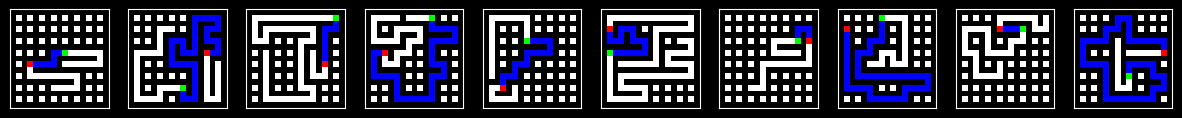

In [5]:
plot_dataset_mazes(DATASET, count=10)

# Some further clarity about what we are trying to find
Now that we have a dataset in the notebook, lets just first demonstrate what behaviour we are trying to understand. Let't take the first maze from the maze dataset.

<ADJLIST_START> (3,7) <--> (3,6) ; (6,5) <--> (5,5) ; (5,5) <--> (5,4) ; (5,3) <--> (5,2) ; (4,1) <--> (5,1) ; (3,5) <--> (3,6) ; (4,6) <--> (4,7) ; (4,4) <--> (4,5) ; (5,2) <--> (5,1) ; (5,4) <--> (5,3) ; (3,7) <--> (4,7) ; (6,5) <--> (6,4) ; (4,6) <--> (4,5) ; (4,1) <--> (4,2) ; (3,3) <--> (3,4) ; (4,3) <--> (3,3) ; (3,5) <--> (3,4) ; (4,3) <--> (4,2) ; (6,3) <--> (6,4) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START> (3,4) (3,3) (4,3) (4,2) (4,1) <PATH_END>


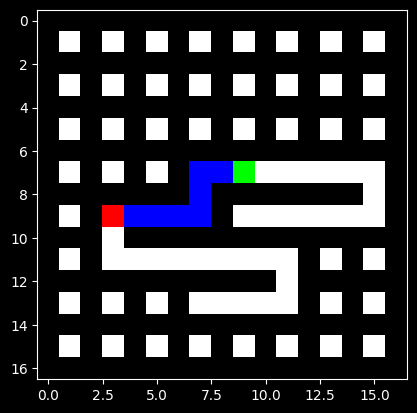

In [6]:
print(" ".join(DATASET[0].as_tokens(DATASET.cfg.node_token_map)))
plt.imshow(DATASET[0].as_pixels())
plt.show()

In the above example, the correct prediction following `<PATH_START>` is the position ~~`(5, 0)`~~. The question we are trying to answer is, given examples of the form above (but with data truncated to the `PATH_START` and some padding at the start to make consistent lengths) how does the model predict ~~`(5, 0)`~~ over any other token?

To explore this behaviour, let's truncate and pad the full dataset of examples we have pulled in.

## Dataset Processing

we want to, for each maze, get a list of context tokens and a list of target tokens. For this example, we get the context tokens by simply looking for the first index of the path start token

In [7]:
ContextGetterFunction = typing.Callable[[list[str]], int]

def get_token_first_index_factory(token: str) -> ContextGetterFunction:
	return lambda token_list: token_list.index(token)

In [8]:
def process_dataset_context_target_pairs(
    dataset_tokens: list[list[str]],
    context_getter: ContextGetterFunction,
) -> tuple[list[list[str]], list[str]]:

	output_contexts: list[list[str]] = list()
	output_targets: list[str] = list()
	for maze in dataset_tokens:
		index: int = context_getter(maze)
		output_contexts.append(maze[:index])
		output_targets.append(maze[index])

	return output_contexts, output_targets

In [12]:
PATH_START_CONTEXT_GETTER: ContextGetterFunction = get_token_first_index_factory(SPECIAL_TOKENS["path_start"])

DATASET_CONTEXTS: list[list[str]]; DATASET_TARGETS: list[str]
DATASET_CONTEXTS, DATASET_TARGETS = process_dataset_context_target_pairs(
    DATASET_TOKENS_UNJOINED,
    context_getter=lambda token_list: PATH_START_CONTEXT_GETTER(token_list) + 1,
)

DATASET_CONTEXTS_JOINED: list[str] = [" ".join(context) for context in DATASET_CONTEXTS]

In [13]:
print(f"context: {' '.join(DATASET_CONTEXTS[0])}")
print(f"target: {DATASET_TARGETS[1]}")

context: <ADJLIST_START> (6,4) <--> (6,3) ; (4,7) <--> (3,7) ; (3,4) <--> (3,5) ; (3,3) <--> (4,3) ; (4,4) <--> (4,5) ; (3,7) <--> (3,6) ; (3,3) <--> (3,4) ; (4,7) <--> (4,6) ; (4,2) <--> (4,1) ; (6,5) <--> (5,5) ; (3,5) <--> (3,6) ; (4,6) <--> (4,5) ; (5,1) <--> (4,1) ; (6,4) <--> (6,5) ; (5,1) <--> (5,2) ; (5,2) <--> (5,3) ; (5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START>
target: (6,4)


Our first question is, how good is the model at predicting the **correct** first token after `PATH_START` in each maze example?

## Model Predictions

In [14]:
# Have the model predict on the maze examples, storing logits and activations in cache
with torch.no_grad():
	LOGITS, CACHE = MODEL.run_with_cache(DATASET_CONTEXTS_JOINED, prepend_bos=False)

In [15]:
print(f'Logits are in the shape {LOGITS.shape}')
print(f'This corresponds to [batch_size, num_tokens, vocab_size]')

Logits are in the shape torch.Size([10, 221, 75])
This corresponds to [batch_size, num_tokens, vocab_size]


We want to predict on the next token (the first path coordinate), thus logits associated with final token.

In [16]:
# Get the last token prediction from the model
last_token_logits = LOGITS[:, -1, :]
predictions = []
for sample in last_token_logits:
    last_token_pred = torch.argmax(sample).item()
    predictions.append(last_token_pred)
predictions = torch.tensor(predictions)
print(f'Prediction are of the shape: {predictions.shape}')
print('This makes sense, we want one prediction for each example in the batch')

Prediction are of the shape: torch.Size([10])
This makes sense, we want one prediction for each example in the batch


Lets have a quick look at what these predictions look like:

In [18]:
print(f'{predictions}\n')
print(f'Converting this back to text gives us: {MODEL.to_str_tokens(predictions)}')
print(f'The targets, for comparison:           {DATASET_TARGETS}')

tensor([33, 56, 60, 36, 23, 21, 48, 20, 44, 43])

Converting this back to text gives us: ['(3,4)', '(6,4)', '(0,7)', '(0,5)', '(2,3)', '(3,0)', '(2,6)', '(0,3)', '(1,5)', '(5,4)']
The targets, for comparison:           ['(3,4)', '(6,4)', '(0,7)', '(0,5)', '(2,3)', '(3,0)', '(2,6)', '(0,3)', '(1,5)', '(5,4)']


Great, we can see what prediction the model is giving based on each maze example in the dataset. Let's see if these predictions match the *ground truth values*.

We can see by comparing the above predictions to these ground truths, the model is indeed very good at predicting the first token after `<PATH_START>`. Let's compare these a little bit more systematically. 

We need to compare the logits associated with the ground truth token to some other token in the dataset, a number of tokens make sense here (ie. a random one, maybe an average over all). However, I think that this token should represent a 'reasonable' wrong response, in this case the most plausible token to me currently seems to be the next token in the dataset (ie. the second token on the ground truth path of each maze). 

In [ ]:
second_tok_on_path = []
for maze in mazes_tokens:
    for idx, tok in enumerate(maze):
        if tok == 6:
            second_tok_on_path.append(maze[idx+2])
            
second_tok_on_path_tokens = torch.stack(second_tok_on_path).long().to(device)

In [ ]:
print(f'Second tokens on the path are: {second_tok_on_path_tokens}\n')
print(f'Converting this back to text gives us: {model.to_str_tokens(second_tok_on_path_tokens)}')

We now have a set of correct tokens (our ground truths for each maze example) and a set of incorrect tokens (in this case just every second token on the maze example's path).

In [ ]:
corrects_incorrects = []
for i in range(len(ground_truth_tokens)):
    corrects_incorrects.append([ground_truth_tokens[i].item(), second_tok_on_path_tokens[i].item()])
correct_incorrect_indices = torch.tensor(corrects_incorrects).long().to(device)

We compare the logit difference across these incorrect and correct tokens.

In [ ]:
# From Neels explanatory notebook: https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/Exploratory_Analysis_Demo.ipynb
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

print("Per prompt logit difference:", logits_to_ave_logit_diff(logits, correct_incorrect_indices, per_prompt=True))
original_average_logit_diff = logits_to_ave_logit_diff(logits, correct_incorrect_indices)
print("Average logit difference:", logits_to_ave_logit_diff(logits, correct_incorrect_indices).item())

The logit difference across the batch is high, it can be interpreted as the model being $e^{11.3}$ more likely to choose the correct repsonse over the incorrect response. Another metric to compare the model's ability is accuracy, defining this below.

In [ ]:
def accuracy(predictions, ground_truths):
    return f'{(predictions.to("cpu") == ground_truths.to("cpu")).sum().item() / len(predictions.to("cpu")):.0%}'

In [ ]:
final_logits = logits[:, -1, :]
answer_logits = final_logits.gather(dim=-1, index=correct_incorrect_indices)
preds = torch.argmax(final_logits, dim=-1)

In [ ]:
preds

Finally, we check accuracy of the predictions against the ground truth values.

In [ ]:
accuracy(preds, ground_truth_tokens)

## Logit Lens

We now use logit lens to decompose the residual stream into contribution of logit difference from individual components. This is done by using the unembedding matrix after each block in the model.

In [ ]:
# Map the correct and incorrect values into the residual stream
correct_incorrect_residual_directions = model.tokens_to_residual_directions(correct_incorrect_indices)
print(f"Correct & Incorrect residual directions shape: {correct_incorrect_residual_directions.shape}")

diff_residual_directions = correct_incorrect_residual_directions[:, 0, :] - correct_incorrect_residual_directions[:, 1, :]
print(f"Correct - Incorrect diff residual directions shape: {diff_residual_directions.shape}")

# cache the values at the end of the residual stream
final_residual_stream = cache["resid_post", -1]
print("Final residual stream shape:", final_residual_stream.shape)

# Get the final token resid stream values (like we did above with last_pred_token)
final_token_residual_stream = final_residual_stream[:, -1, :]

# Scaling the values in residual stream with layer norm
scaled_final_token_residual_stream = cache.apply_ln_to_stack(final_token_residual_stream, layer = -1, pos_slice=-1)

# Average logit diff from residual stream method
average_logit_diff = einsum("batch d_model, batch d_model -> ", scaled_final_token_residual_stream, diff_residual_directions) / n_examples
print("Calculated average logit diff:", average_logit_diff.item())
print("Original logit difference:",original_average_logit_diff.item())

In [ ]:
def residual_stack_to_logit_diff(residual_stack: Float[torch.Tensor, "components batch d_model"], cache: ActivationCache) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer = -1, pos_slice=-1)
    return einsum("... batch d_model, batch d_model -> ...", scaled_residual_stack, diff_residual_directions)/n_examples

We first look at the logit difference from the accumulated residual stream, this means we are looking at the logit difference between the correct at: 
1. Layer 0 resid_mid, 
2. Accumulated across layer 0 resid_mid + layer 0 resid_post, 
3. Accumulated across layer 0 resid_mid + layer 0 resid_post + layer 1 resid_mid,
4. etc.

    ...

    Accumulated logit difference from entire resid stream.

In [ ]:
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache)
line(logit_lens_logit_diffs, x=np.arange(model.cfg.n_layers*2+1)/2, hover_name=labels, title="Logit Difference From Accumulated Residual Stream")

Here we see that model seems to be largely unable to do this task until around layer 8, we also see a signficant contribution between layer 11 resid_mid and layer 11 resid_post (indicating a large influence of the Layer 11 MLP on this task).

We can also look at the logit difference contribution for layer in isolation (removing the cumulative effect of previous layers).

In [ ]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

What is this suggesting:
* MLP11 is really important and MLP8, MLP9 and MLP10 are quite important

* It doesnt appear to be the case that attention is very important

## Direct Logit Attribution

We now move onto applying the same techique but at the level of individual heads and neurons (as opposed to entire layer or blocks).

In [ ]:
# One of Jett's plotting functions from here: https://github.com/jettjaniak/mi_utils_public/blob/main/plotting.py
def imshow(
    tensor,
    xlabel="X",
    ylabel="Y",
    zlabel=None,
    xticks=None,
    yticks=None,
    c_midpoint=0.0,
    c_scale="RdBu",
    show=True,
    **kwargs
):
    tensor = et_utils.to_numpy(tensor)
    if "animation_frame" not in kwargs:
        assert len(tensor.shape) == 2
    else:
        assert len(tensor.shape) == 3
    xticks = xticks or range(tensor.shape[-1])
    yticks = yticks or range(tensor.shape[-2])
    xticks = [str(x) for x in xticks]
    yticks = [str(y) for y in yticks]
    if len(xticks) != len(set(xticks)):
        xticks = [f"{i}_{x}" for i, x in enumerate(xticks)]
    if len(yticks) != len(set(yticks)):
        yticks = [f"{i}_{y}" for i, y in enumerate(yticks)]
    labels = {"x": xlabel, "y": ylabel}
    if zlabel is not None:
        labels["color"] = zlabel
    fig = px.imshow(
        et_utils.to_numpy(tensor),
        x=xticks,
        y=yticks,
        labels=labels,
        color_continuous_midpoint=c_midpoint,
        color_continuous_scale=c_scale,
        **kwargs
    )
    if show:
        fig.show()
    else:
        return fig

In [ ]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_diffs = einops.rearrange(per_head_logit_diffs, "(layer head_index) -> layer head_index", layer=model.cfg.n_layers, head_index=model.cfg.n_heads)
imshow(per_head_logit_diffs, xlabel = "Heads", ylabel = "Layer", title="Logit Difference From Each Head", aspect="auto")

These results are suggestive of various heads (those in blue) having a positive effect on logit difference, their effect however is relatively small (only amounting for example to a 0.05 increase in logits for the correct response vs the incorrect response).

In [ ]:
per_neuron_residual, labels = cache.stack_neuron_results(layer=-1, pos_slice=-1, return_labels=True)
per_neuron_logit_diffs = residual_stack_to_logit_diff(per_neuron_residual, cache)
per_neuron_logit_diffs = einops.rearrange(per_neuron_logit_diffs, "(layer neuron_index) -> layer neuron_index", layer=model.cfg.n_layers, neuron_index=model.cfg.d_mlp)
imshow(per_neuron_logit_diffs, xlabel = 'Neuron Index', ylabel = "Layer", aspect = "auto", title="Logit Difference From Each Neuron")

In [ ]:
percentile = 0.01
top_neuron_logit_diffs = []
per_neuron_logit_diffs = per_neuron_logit_diffs.to("cpu").numpy()
for idx, layer in enumerate(per_neuron_logit_diffs):
    top_sorted_layer = (np.sort(layer)[-int(percentile*len(layer)):])
    top_of_layer = []
    for idx, neuron in enumerate(layer):
        if neuron in top_sorted_layer:
            top_of_layer.append((int(idx), neuron))
    top_neuron_logit_diffs.append(top_of_layer)
top_neuron_logit_diffs = np.array(top_neuron_logit_diffs)

In [ ]:
fig = px.imshow(top_neuron_logit_diffs[:, :, 1],
                y = [y for y in range(0, model.cfg.n_layers, 1)], 
                color_continuous_scale='RdBu', 
                color_continuous_midpoint=0.0, 
                aspect="auto",
                title=f"Logit Difference From Top {percentile:.1%} Neurons in each Layer")

fig.update_xaxes(showticklabels = False)
fig.update_traces(text = top_neuron_logit_diffs[:, :, 0], texttemplate = "%{text}")
fig.show()

These results are also suggestive that the MLPs are doing most of the computation.

## Activation Patching

In this section, we get more rigorous with our analysis by employing activation patching. 

**An important note here**: All functions set up in this section are predicated on returning a normalised change from patching in a corrupt activation into an otherwise clean run. 

This differs from some other implementations in that it is a returning normalised logit difference (like in Neel's Exploratory Analysis Demo) but patching a corrupt activation into a clean run (like in Jett's Docstring work). Personally, I feel this makes most intuitive sense, we want to understand how important a single component is toward performing a task in context of the rest of the model and logits by themselves are less intuitive than normalized effects. In this sense, a negetaive number corresponds to a loss of performance (more negative = larger loss in performance), 0 corresponds to no change and a positive number corresponds to an active improvement by removing that component.

We start by running two forward passes, in this case the corrupted_tokens = (clean_token with ORIGIN and PATH_START tokens replaced with a random token)

In [ ]:
# Clean tokens are just our original padded tokens
clean_tokens = padded_tokens

# Corrupted tokens are our original padded tokens with ORIGIN and PATH_START tokens replaced with random tokens
corrupted_tokens = padded_tokens.clone()

# Replace PATH_START tokens
corrupted_tokens[:,-1] = torch.randint(0, model.cfg.d_vocab, (1,))

# Replace ORIGIN tokens
corrupted_tokens[:, -6] = torch.randint(0, model.cfg.d_vocab, (1,))

# Corrupt Forward Pass
print(f'First Corrupt Prompt: {model.to_str_tokens(corrupted_tokens[0])}\n')
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, prepend_bos=True)

# Clean Forward Pass
print(f'First Clean Prompt: {model.to_str_tokens(clean_tokens[0])}\n')
clean_logits, clean_cache = model.run_with_cache(clean_tokens, prepend_bos=True)

In [ ]:
def logit_diff(logits, correct_incorrect_indices=correct_incorrect_indices, pos=-1):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, pos, :]
    correct_logits = logits.gather(1, correct_incorrect_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, correct_incorrect_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

clean_logit_diff = logit_diff(clean_logits, correct_incorrect_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logit_diff(corrupted_logits, correct_incorrect_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

In [ ]:
CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff
def counting_metric(logits, answer_token_indices=correct_incorrect_indices):
    return (logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE) - 1

print(f"Clean Baseline is 0: {counting_metric(clean_logits).item():.4f} - This corresponds to no loss in performance\n")
print(f"Corrupted Baseline is -1: {counting_metric(corrupted_logits).item():.4f} - This corresponds to a complete loss in performance\n")
print(f'A counting metric of > 0 corresponds to a an active improvement in performance\n')

We set up a function to do resdiual stream pre patching, we call this the `resid_patcher`.

In [ ]:
def resid_patcher(layer: int,
                pos: int,
                clean_tokens: TT["batch", "pos"],
                corrupted_tokens: TT["batch", "pos"] = None,
                corrupted_cache: ActivationCache = None,
                prepend_bos: bool = True):

    if corrupted_cache is None:
        _, corrupted_cache = model.run_with_cache(corrupted_tokens, prepend_bos=prepend_bos)
    
    def patch_clean_head_vector(
        clean_head_vector: TT["batch pos head_index d_head"],
        hook, 
        corrupted_cache):
        clean_head_vector[:, pos, :] = corrupted_cache[hook.name][:, pos, :]
        return clean_head_vector
    
    hook_fn = partial(patch_clean_head_vector, corrupted_cache=corrupted_cache)

    activation_name = utils.get_act_name("resid_pre", layer)
    patched_logits = model.run_with_hooks(
            clean_tokens,
            fwd_hooks = [(activation_name, hook_fn)],
            return_type = "logits",
            )
    
    model.reset_hooks()

    return patched_logits

We then apply this `resid_patcher` recursively over each layer at each postion in the model to see what part of the resid stream is playing an integral role in this task.

In [ ]:
def recursive_resid_patching(clean_tokens: TT["batch", "pos"],
                            corrupted_cache: ActivationCache | None = None,
                            pos: int = -1):

    if pos:
        resid_patches = torch.zeros(model.cfg.n_layers, 1, device = device, dtype = torch.float32)
        for layer in range(model.cfg.n_layers):
                patched_logit_diff = counting_metric(resid_patcher(
                                                            layer = layer, 
                                                            pos = pos, 
                                                            clean_tokens = clean_tokens, 
                                                            corrupted_cache = corrupted_cache
                                                            ), correct_incorrect_indices).item()
                resid_patches[layer] = patched_logit_diff

    else:
        all_pos = [x for x in range(len(clean_tokens[0]))]
        resid_patches = torch.zeros(model.cfg.n_layers, len(all_pos), device = device, dtype = torch.float32)
        for pos in all_pos:
            for layer in range(model.cfg.n_layers):
                patched_logit_diff = counting_metric(resid_patcher(
                                                            layer = layer, 
                                                            pos = pos, 
                                                            clean_tokens = clean_tokens, 
                                                            corrupted_cache = corrupted_cache
                                                            ), correct_incorrect_indices).item()
                resid_patches[layer, pos] = patched_logit_diff
                    
    return resid_patches

In [ ]:
resid_patches = recursive_resid_patching(clean_tokens, corrupted_cache, pos = None)

We write a quick function to visualize these results, `resid_patching_imshow`.

In [ ]:
def resid_patching_imshow(resid_patches, layer_labels, pos_labels):
    fig = imshow(resid_patches, 
            title = 'Normalised Change in Logit Diff Performance From Patched Resid Pre at Given position', 
            aspect = "auto", 
            xlabel= "Pos", 
            ylabel= "Layer",
            xticks = pos_labels,
            yticks = layer_labels,
            height = 720,
            width = 720)

We make the visualisation easier to read by labelling the positions along the x-axis and layers along the y-axis.

In [ ]:
pos_labels = model.to_str_tokens(clean_tokens[0])
layer_labels = [f"Layer {layer}" for layer in range(model.cfg.n_layers)]

In [ ]:
resid_patching_imshow(resid_patches=resid_patches,
                      layer_labels=layer_labels,
                      pos_labels=pos_labels)

These results are suggestive of signficant computation occuring at the `ORIGIN_START` token within the model's early layers and across many layers for the `PATH_START` token.

We can get much more granular than this by performing activation patching on individual attn heads.

We start by restating our clean and corrupt forward passes.

In [ ]:
# Corrupt Forward Pass
print(f'First Corrupt Prompt: {model.to_str_tokens(corrupted_tokens[0])}\n')
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, prepend_bos=True)

# Clean Forward Pass
print(f'First Clean Prompt: {model.to_str_tokens(clean_tokens[0])}\n')
clean_logits, clean_cache = model.run_with_cache(clean_tokens, prepend_bos=True)

resid_patches = recursive_resid_patching(clean_tokens, corrupted_cache, pos = None)

clean_logit_diff = logit_diff(clean_logits, correct_incorrect_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logit_diff(corrupted_logits, correct_incorrect_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff
def counting_metric(logits, answer_token_indices=correct_incorrect_indices):
    return (logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE) - 1

As before, we define a generic function to patch over any head in the model at any specified position, we call this the `head_patcher`.

In [ ]:
def head_patcher(layer: int,
                head_index: int,
                pos: int,
                clean_tokens: TT["batch", "pos"],
                corrupted_tokens: TT["batch", "pos"] = None,
                corrupted_cache: ActivationCache = None,
                prepend_bos: bool = True,
                comp = None):

    if corrupted_cache is None:
        _, corrupted_cache = model.run_with_cache(corrupted_tokens, prepend_bos=prepend_bos)
    
    def patch_clean_head_vector(
        clean_head_vector: TT["batch pos head_index d_head"],
        hook, 
        head_index, 
        corrupted_cache):
        clean_head_vector[:, pos, head_index, :] = corrupted_cache[hook.name][:, pos, head_index, :]
        return clean_head_vector
    
    hook_fn = partial(patch_clean_head_vector, head_index=head_index, corrupted_cache=corrupted_cache)

    if comp is None:
        activation_name = utils.get_act_name("z", layer, "attn")
        patched_logits = model.run_with_hooks(
                clean_tokens,
                fwd_hooks = [(activation_name, hook_fn)],
                return_type = "logits",
                )

    else:
        assert comp in ["q", "k", "v"]
        activation_name = f"blocks.{layer}.attn.hook_{comp}"

    patched_logits = model.run_with_hooks(
                    clean_tokens,
                    fwd_hooks = [(activation_name, hook_fn)],
                    return_type = "logits",
                    )
    
    model.reset_hooks()

    return patched_logits

We use this function to patch over (Layer 10, Head 0) at the `PATH_START` position.

In [ ]:
head_patched_logits = head_patcher(10, 0, -1, clean_tokens, corrupted_tokens, comp = None)
original_logit_diff = counting_metric(clean_logits, correct_incorrect_indices).item()
patched_head_logit_diff = counting_metric(head_patched_logits, correct_incorrect_indices).item()
print(f"Original logit diff: {original_logit_diff:.4f}\n")
print(f"Patched logit diff: {patched_head_logit_diff:.4f}\n")

We find that patching over this head as a *very* small negative effect on the models ability to do the PATH_START task. Remember for reference, a result of 0 is literally no change, -1 is a complete loss in ability to do the task and a result > 0 is an active improvement in the model's ability to do the task.

As before, we set up another function that calls the `head_patcher` to recursively check every head at every position.

In [ ]:
def recursive_head_patching(clean_tokens: TT["batch", "pos"],
                            corrupted_cache: ActivationCache = None,
                            comp: str | None = None, 
                            pos: int | None = -1):

    if pos:
        head_patches = torch.zeros(model.cfg.n_layers, model.cfg.n_heads, device = device, dtype = torch.float32)
        for layer in range(model.cfg.n_layers):
            for head in range(model.cfg.n_heads):
                patched_logit_diff = counting_metric(head_patcher(layer = layer, 
                                            head_index = head, 
                                            pos = pos, 
                                            clean_tokens = clean_tokens, 
                                            corrupted_cache = corrupted_cache, 
                                            comp = comp), correct_incorrect_indices).item()
                head_patches[layer, head] = patched_logit_diff

    else:
        all_pos = [x for x in range(len(clean_tokens[0]))]
        head_patches = torch.zeros(model.cfg.n_layers*model.cfg.n_heads, len(all_pos), device = device, dtype = torch.float32)
        for pos in all_pos:
            for layer in range(model.cfg.n_layers):
                for head in range(model.cfg.n_heads):
                    head_idx = layer*model.cfg.n_heads + head
                    patched_logit_diff = counting_metric(head_patcher(layer = layer, 
                                                                head_index = head, 
                                                                pos = pos, 
                                                                clean_tokens = clean_tokens, 
                                                                corrupted_cache = corrupted_cache, 
                                                                comp = comp), correct_incorrect_indices).item()
                    head_patches[head_idx, pos] = patched_logit_diff
                    
    return head_patches

In [ ]:
head_patches = recursive_head_patching(clean_tokens, corrupted_cache, comp = None, pos = None)

Another generic function to make visualising the results easy.

In [ ]:
def head_patching_imshow(head_patches, layerhead_labels, pos_labels):
    fig = imshow(head_patches, 
            title = 'Normalised Change in Logit Diff Performance From Patched Head at Given position', 
            aspect = "auto", 
            xlabel= "Pos", 
            ylabel= "Layer",
            xticks = pos_labels,
            yticks = layerhead_labels,
            height = 720,
            width = 720)

Creating a label for every head in the model for visualization of the form: Layer.Head (ie. Layer 10 Head 5 => 10.5).

In [ ]:
layerhead_labels = [f"{layer}.{head}" for layer in range(model.cfg.n_layers) for head in range(model.cfg.n_heads)]

In [ ]:
head_patching_imshow(head_patches, layerhead_labels, pos_labels)

We now crease a function to collect large effects across all of these recursive runs to make it easier to pull out the most meaningful activation patching results.

In [ ]:
def collect_large_effect(patching_effect, threshold):
    for head_idx, head_value in enumerate(patching_effect):
        for pos_idx, pos_value in enumerate(head_value):
            layer = str(head_idx // 12)
            head = str(head_idx % 12)
            # If patching over causes greater than the threshold normalized logit diff drop decrease in performance print it out
            if pos_value < -threshold:
                print(f'Layer {layer} Head {head} has a large negative effect if removed at position: "{pos_labels[pos_idx]}" with perf. change of {pos_value:.2f}.')
            # If patching over causes greater than the threshold normalized logit diff gain in performance print it out
            if pos_value > threshold:
                print(f'Layer {layer} Head {head} has a large positive effect if removed at position: "{pos_labels[pos_idx]}" with perf. change of {pos_value:.2f}.')

We run this function on the head patching results and find that there are a few early layer heads at the `ORIGIN` token and `PATH_START` token positions that if patched over have a considerably large negative effect on performance.

In [ ]:
collect_large_effect(head_patches, 0.1) # Note the choice of a 0.1 threshold is arbitrary but seems to strike a balance between finding interesting results and not printing too much

It does appear to be the case that the following heads are doing meaningful computation for this task:

* Layer 0 Head 0 at the `PATH_START` token
* Layer 0 Head 2 at the `ORIGIN` token
* Layer 0 Head 2 at the `PATH_START` token
* Layer 0 Head 3 at the `PATH_START` token
* Layer 0 Head 4 at the `PATH_START` token
* Layer 1 Head 1 at the `PATH_START` token
* Layer 3 Head 9 at the `PATH_START` token

One hypothesis here is that (1.1 and 3.9) act as ORIGIN_TOKEN movers that are active on the PATH_START token and compose with the ORIGIN token (via key/values). Additionally, it may be the case Layer 0 Head 2 is passing information to these heads about the ORIGIN token but it is unclear what this looks like currently.

We will undertake a similar investigation with the MLPs, first setting up a generic `mlp_patcher`.

In [ ]:
def mlp_patcher(layer: int, 
				pos: int, 
				clean_tokens: TT["batch", "pos"],
				corrupted_tokens: TT["batch", "pos"] = None,
				corrupted_cache: ActivationCache = None, 
				prepend_bos=True):

	if corrupted_cache is None:
		_, corrupted_cache = model.run_with_cache(corrupted_tokens, prepend_bos=prepend_bos)

	def patch_clean_head_vector(
		clean_head_vector: Float[torch.Tensor, "batch pos d_head"],
		hook, 
		corrupted_cache):
		clean_head_vector[:, pos, :] = corrupted_cache[hook.name][:, pos, :]
		return clean_head_vector

	hook_fn = partial(patch_clean_head_vector, corrupted_cache=corrupted_cache)
	activation_name = f'blocks.{layer}.hook_mlp_out'

	patched_logits = model.run_with_hooks(
					clean_tokens,
					fwd_hooks = [(activation_name, hook_fn)],
					return_type = "logits",
					)
	
	model.reset_hooks()

	return patched_logits

Again we use our generic `mlp_patcher` to set up a function to recursively patch over each MLP at each position. 

In [ ]:
def recursive_mlp_patching(clean_tokens: TT["batch", "pos"],
                            corrupted_cache: ActivationCache | None = None,
                            pos: int = -1):

    if pos:
        mlp_patches = torch.zeros(model.cfg.n_layers, 1, device = device, dtype = torch.float32)
        for layer in range(model.cfg.n_layers):
                patched_logit_diff = counting_metric(mlp_patcher(
                                                            layer = layer, 
                                                            pos = pos, 
                                                            clean_tokens = clean_tokens, 
                                                            corrupted_cache = corrupted_cache
                                                            ), correct_incorrect_indices).item()
                mlp_patches[layer] = patched_logit_diff

    else:
        all_pos = [x for x in range(len(clean_tokens[0]))]
        mlp_patches = torch.zeros(model.cfg.n_layers, len(all_pos), device = device, dtype = torch.float32)
        for pos in all_pos:
            for layer in range(model.cfg.n_layers):
                patched_logit_diff = counting_metric(mlp_patcher(
                                                            layer = layer, 
                                                            pos = pos, 
                                                            clean_tokens = clean_tokens, 
                                                            corrupted_cache = corrupted_cache
                                                            ), correct_incorrect_indices).item()
                mlp_patches[layer, pos] = patched_logit_diff
                    
    return mlp_patches

In [ ]:
mlp_patches = recursive_mlp_patching(clean_tokens, corrupted_cache, pos = None)

Finally setting up a similar plotting function to easily visualize results.

In [ ]:
def mlp_patching_imshow(mlp_patches, pos_labels):
    fig = imshow(mlp_patches, 
            title = 'Normalised Change in Logit Diff Performance From Patched MLP Block at Given position', 
            aspect = "auto", 
            xlabel= "Position", 
            ylabel= "Layer",
            xticks = pos_labels,
            height = 720,
            width = 720)

In [ ]:
mlp_patching_imshow(mlp_patches, pos_labels)

These results suggest the following:
* Patching over either MLP0 or MLP1 on the ORIGIN token has a significant effect on the model's ability to do this task.
* Patching over MLP0, MLP1, MLP2, MLP5, MLP8, MLP9, MLP10 or MLP11 on the PATH_START token has a significant effect on the model's ability to this task.

We can also get check that our original activation patching was capturing all important positions by setting all of the tokens in the corrupt dataset to random tokens, this analysis will take considerably longer to run though. After this analysis, we will move back to corrupting individual tokens. 

In [ ]:
# Start by patching the END token with a random value from the model's vocab
corrupted_tokens = torch.randint_like(clean_tokens, 0, model.cfg.d_vocab) 

# Corrupt Forward Pass
print(f'First Corrupt Prompt: {model.to_str_tokens(corrupted_tokens[0])}\n')
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, prepend_bos=True)

# Clean Forward Pass
print(f'First Clean Prompt: {model.to_str_tokens(clean_tokens[0])}\n')
clean_logits, clean_cache = model.run_with_cache(clean_tokens, prepend_bos=True)

clean_logit_diff = logit_diff(clean_logits, correct_incorrect_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logit_diff(corrupted_logits, correct_incorrect_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff
def counting_metric(logits, answer_token_indices=correct_incorrect_indices):
    return (logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE) - 1

In [ ]:
head_patching = recursive_head_patching(clean_tokens = clean_tokens, corrupted_cache = corrupted_cache, comp = None, pos = None)
head_patching_imshow(head_patching, layerhead_labels = layerhead_labels, pos_labels=pos_labels)
collect_large_effect(head_patching, 0.1) # Again arbitrary threshold

As before, we find a number of heads that are important on the PATH_START and ORIGIN tokens, here we find that there is also important computation occuring at the ADJLIST_END token.

Doing the same for the MLPs.

In [ ]:
mlp_patching = recursive_mlp_patching(clean_tokens = clean_tokens, corrupted_cache = corrupted_cache, pos = None)
mlp_patching_imshow(mlp_patching, pos_labels=pos_labels)

Again we see important computation occuring not only on the ORIGIN and PATH_START token but also at the ADJLIST_END token.

This analysis will continue by patching over each of these tokens individually, first at PATH_START, then ORIGIN and then the ADJLIST_END token.

However, thus far it does still appear to the case that a significant amount of this task is being achieved by MLPs. This is counterintuitive for a task of this nature (which just involves passing information from one token (the ORIGIN token) that is always sandwiched between ORIGIN_START and ORIGIN_END to another token (the PATH_START token)). Some further behavioural analysis conducted outside of this notebook suggests that this instance of maze-transformer is not capable of doing this task on out-of-distribution examples. For this reason, the analysis will be paused here.